Author: Nik Alleyne <br>
Author Blog: **https://www.securitynik.com** <br>
Author GitHub: **github.com/securitynik** <br>

Author Books: [  <br>

                "https://www.amazon.ca/Learning-Practicing-Leveraging-Practical-Detection/dp/1731254458/", 
                
                "https://www.amazon.ca/Learning-Practicing-Mastering-Network-Forensics/dp/1775383024/" 
            ] 


### Why this series?
When teaching the SANS SEC595: Applied Data Science and Machine Learning for Cybersecurity Professionals 
**https://www.sans.org/cyber-security-courses/applied-data-science-machine-learning/** I am always asked,
"Will you be sharing your demo notebooks?" or "Can we get a copy of your demo notebooks?" or ... well you get the point.
My answer is always no. Not that I do not want to share, (sharing is caring :-D) , but the demo notebooks 
by themselves, would not make sense or add real value. Hence, this series! 

This is my supplemental work, similar to what I would do in the demos but with a lot more details and references.


## 23 - Continuing Anomaly Learning - Zeek DNS Log - Machine Learning

### The series includes the following: <br>
01 - Beginning Numpy <br>
02 - Beginning Tensorflow  <br>
03 - Beginning PyTorch <br>
04 - Beginning Pandas <br>
05 - Beginning Matplotlib <br>
06 - Beginning Data Scaling <br>
07 - Beginning Principal Component Analysis (PCA) <br>
08 - Beginning Machine Learning Anomaly Detection - Isolation Forest and Local Outlier Factor <br>
09 - Beginning Unsupervised Machine Learning - Clustering - K-means and DBSCAN <br>
10 - Beginning Supervise Learning - Machine Learning - Logistic Regression, Decision Trees and Metrics <br>
11 - Beginning Linear Regression - Machine Learning <br>
12 - Beginning Deep Learning - Anomaly Detection with AutoEncoders, Tensorflow <br>
13 - Beginning Deep Learning - Anomaly Detection with AutoEncoders, PyTroch <br>
14 - Beginning Deep Learning - Linear Regression, Tensorflow <br>
15 - Beginning Deep Learning - Linear Regression, PyTorch <br>
16 - Beginning Deep Learning - Classification, Tensorflow <br>
17 - Beginning Deep Learning - Classification, Pytorch <br>
18 - Beginning Deep Learning - Classification - regression - MIMO - Functional API Tensorflow <br> 
19 - Beginning Deep Learning - Convolution Networks - Tensorflow <br>
20 - Beginning Deep Learning - Convolution Networks - PyTorch <br>
21 - Beginning Regularization - Early Stopping, Dropout, L2 (Ridge), L1 (Lasso) <br>
22 - Beginning Model TFServing <br>

But conn.log is not the only log file within Zeek. Let's build some models for DNS and HTTP logs. <br>
I choose unsupervised, because there are no labels coming with these data. <br>

23 - Continuing Anomaly Learning - Zeek DNS Log - Machine Learning <br>
24 - Continuing Unsupervised Learning - Zeek HTTP Log - Machine Learning <br>

This was a specific ask by someone in one of my class. <br>
25 - Beginning - Reading Executables and Building a Neural Network to make predictions on suspicious vs suspicious  <br><br>

With 25 notebooks in this series, it is quite possible there are things I could have or should have done differently.  <br>
If you find any thing, you think fits those criteria, drop me a line. <br>

If you find this series beneficial, I would greatly appreciate your feedback.

While everything done so far has used the conn.log, this is not the only log file that Zeek creates

Zeek creates a log file for everything protocol it sees via its monitoring interface(s)

Here is a list of some of the log sources on my lab system

securitynik@lab:~$ **ls /opt/zeek/logs/current/**<br>
capture_loss.log &emsp; dns.log &emsp; known_hosts.log &emsp; ntp.log &emsp; ssh.log &emsp; stderr.log &emsp; telemetry.log <br>
conn.log &emsp; files.log &emsp; known_services.log &emsp; ocsp.log &emsp; ssl.log &emsp; stdout.log &emsp; weird.log<br>
dhcp.log &emsp; http.log &emsp; notice.log &emsp; software.log &emsp; stats.log &emsp; syslog.log &emsp; x509.log<br>

For a list of protocols Zeek supports, see: <br>
https://docs.zeek.org/en/master/script-reference/proto-analyzers.html


With that understanding in place, let's get data from the dns.log file <br>
securitynik@lab:/opt/zeek/logs/current$ **zeek-cut id.orig_h id.orig_p id.resp_h id.resp_p proto trans_id rtt query < dns.log > /tmp/zeek_dns.log**


Transfer the file to my development machine

PS D:\OtherML\Beginning_ML> **scp securitynik@peeper:/tmp/zeek_dns.log .** <br>
securitynik@peeper's password:  <br>
zeek_dns.log                                                                  100%  376KB   6.9MB/s   00:00

In [1]:
# import some libraries
import pandas as pd
import numpy as np

In [2]:
# Read the DNS data
# We learned about Pandas in the notebook
#   04 - Beginning Pandas
df_dns = pd.read_csv(filepath_or_buffer=r'./zeek_dns.log', header=None, sep='\t', \
                     names=['id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p', 'proto', \
                            'trans_id', 'rtt', 'query', 'qtype'], na_values=['-','', '0']).reset_index(drop=True)

# The results return shows we have 5431 records with 8 columns
df_dns

,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,trans_id,rtt,query,qtype
0,10.10.0.33,49925,10.10.0.2,53,udp,28568.0,0.000354,dealer.spotify.com,1
1,10.10.0.4,35772,10.10.0.2,53,udp,28660.0,NaN,33.0.10.10.in-addr.arpa,12
2,10.10.0.4,36269,10.10.0.2,53,udp,458.0,0.000190,2.0.10.10.in-addr.arpa,12
3,10.10.0.4,35237,10.10.0.2,53,udp,10874.0,NaN,4.0.10.10.in-addr.arpa,12
4,10.10.0.4,54360,10.10.0.2,53,udp,11233.0,0.017187,25.224.186.35.in-addr.arpa,12
...,...,...,...,...,...,...,...,...,...
1454,10.10.0.52,49963,10.10.0.2,53,udp,12012.0,0.016614,teams.events.data.microsoft.com,65
1455,10.10.0.52,54029,10.10.0.2,53,udp,38566.0,0.018393,teams.events.data.microsoft.com,1
1456,10.10.0.32,49937,10.10.0.2,53,udp,2.0,0.010588,pool.ntp.org,1
1457,10.10.0.4,45990,10.10.0.2,53,udp,65144.0,0.000254,labsys.sn.local,1


This file represents Zeek (formerly Bro) DNS log - dns.log`. 
Zeek is a framework used for Network Security Monitoring. 
This entire series is based on using Zeek's data. 
The majority of the notebooks use the conn.log
You can learn more about Zeek here:
   
    https://zeek.org/

Alternatively, come hang out with us in the:
SANS SEC595: Applied Data Science and Machine Learning for Cybersecurity Professionals

        https://www.sans.org/cyber-security-courses/applied-data-science-machine-learning/ OR

SEC503 SEC503: Network Monitoring and Threat Detection In-Depth

        https://www.sans.org/cyber-security-courses/network-monitoring-threat-detection/


Here are also some blog posts on using Zeek for security monitoring
Installing Zeek: 

        https://www.securitynik.com/2020/06/installing-zeek-314-on-ubuntu-2004.html

Detecting PowerShell Empire Usage: 

        https://www.securitynik.com/2022/02/powershell-empire-detection-with-zeek.html

Detecting Log4J Vulnerability Exploitation: 

        https://www.securitynik.com/2021/12/continuing-log4shell-zeek-detection.html

In [3]:
# Let's look at the info of the dataset
df_dns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id.orig_h  1459 non-null   object 
 1   id.orig_p  1459 non-null   int64  
 2   id.resp_h  1459 non-null   object 
 3   id.resp_p  1459 non-null   int64  
 4   proto      1459 non-null   object 
 5   trans_id   1387 non-null   float64
 6   rtt        904 non-null    float64
 7   query      1459 non-null   object 
 8   qtype      1459 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.7+ KB


In [4]:
# Do we have any rows that is reporting as null
#   https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isnull.html
# RTT and Trans_id columns have null values
df_dns.isnull().sum()

id.orig_h      0
id.orig_p      0
id.resp_h      0
id.resp_p      0
proto          0
trans_id      72
rtt          555
query          0
qtype          0
dtype: int64

In [5]:
# A different view
#   https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isna.html
# Same here
df_dns.isna().sum()

id.orig_h      0
id.orig_p      0
id.resp_h      0
id.resp_p      0
proto          0
trans_id      72
rtt          555
query          0
qtype          0
dtype: int64

In [6]:
# Describing the data to identify what value to fill the missing fields with
df_dns.describe()

,id.orig_p,id.resp_p,trans_id,rtt,qtype
count,1459.000000,1459.000000,1387.000000,904.000000,1459.000000
mean,43859.629198,605.745716,31699.491709,0.012335,18.544894
std,18735.515226,1619.529960,20002.637676,0.012749,36.449975
min,137.000000,53.000000,1.000000,0.000032,1.000000
25%,36046.000000,53.000000,13724.500000,0.000254,1.000000
50%,50070.000000,53.000000,32797.000000,0.013045,1.000000
75%,57927.000000,53.000000,48913.000000,0.018371,28.000000
max,65535.000000,5355.000000,65527.000000,0.155132,255.000000


In [7]:
# Grab the median for the two columns with null values
# No need to do transaction ID. This will be dropped. 
# This ID is a random value and I don't believe will make this model any better 
#rtt_median =  df_dns.rtt.median()
#rtt_median

In [8]:
# Immediately, se we can see rtt field with NaN values
# We will need to address those
df_dns[df_dns.isna().any(axis=1)]

,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,trans_id,rtt,query,qtype
1,10.10.0.4,35772,10.10.0.2,53,udp,28660.0,NaN,33.0.10.10.in-addr.arpa,12
3,10.10.0.4,35237,10.10.0.2,53,udp,10874.0,NaN,4.0.10.10.in-addr.arpa,12
6,10.10.0.4,58550,10.10.0.2,53,udp,18765.0,NaN,24.0.10.10.in-addr.arpa,12
9,10.10.0.4,49434,10.10.0.2,53,udp,13182.0,NaN,74.0.10.10.in-addr.arpa,12
11,10.10.0.4,56323,10.10.0.2,53,udp,23090.0,NaN,32.0.10.10.in-addr.arpa,12
...,...,...,...,...,...,...,...,...,...
1442,10.10.0.4,59993,10.10.0.2,53,udp,21792.0,NaN,labsys.sn.local,1
1443,10.10.0.4,37556,10.10.0.2,53,udp,28269.0,NaN,labsys.sn.local,28
1449,10.10.0.10,5353,224.0.0.251,5353,udp,2485.0,NaN,_googlecast._tcp.local,12
1452,10.10.0.4,43222,10.10.0.2,53,udp,24636.0,NaN,otx.alienvault.com,28


In [9]:
# Above we have 569 rows returned
# Fill the rtt column with the median value of the column
df_dns['rtt'] = df_dns['rtt'].fillna(value=df_dns.rtt.median(), axis=0, inplace=False)

# Validate the field have been filled in
# Below we see rtt at 0. 
df_dns.isnull().sum()

id.orig_h     0
id.orig_p     0
id.resp_h     0
id.resp_p     0
proto         0
trans_id     72
rtt           0
query         0
qtype         0
dtype: int64

In [10]:
# Get the datatypes 
df_dns.dtypes

id.orig_h     object
id.orig_p      int64
id.resp_h     object
id.resp_p      int64
proto         object
trans_id     float64
rtt          float64
query         object
qtype          int64
dtype: object

In [11]:
# Revisit the info again
# This basically confirms what we have above
df_dns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id.orig_h  1459 non-null   object 
 1   id.orig_p  1459 non-null   int64  
 2   id.resp_h  1459 non-null   object 
 3   id.resp_p  1459 non-null   int64  
 4   proto      1459 non-null   object 
 5   trans_id   1387 non-null   float64
 6   rtt        1459 non-null   float64
 7   query      1459 non-null   object 
 8   qtype      1459 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.7+ KB


In [12]:
# We that in place moving on ..
# We will drop some of the fields eventually, for now, let's focus on the query
# The query is a text field and we want to break it into 3 sections. For example www.securitynik.com
#   1. Top Level Domain (TLD) -> com
#   2. domain -> securitynik
#   3. sub-domain   -> www
#   https://www.wix.com/blog/2020/12/what-is-tld/

# Let's split those field from the perspective of right to left
df_dns['query'].str.rsplit(pat='.', n=2, expand=True)

,0,1,2
0,dealer,spotify,com
1,33.0.10.10,in-addr,arpa
2,2.0.10.10,in-addr,arpa
3,4.0.10.10,in-addr,arpa
4,25.224.186.35,in-addr,arpa
...,...,...,...
1454,teams.events.data,microsoft,com
1455,teams.events.data,microsoft,com
1456,pool,ntp,org
1457,labsys,sn,local


In [13]:
# Let's add these to our existing dataframe
df_dns[['sub_domain', 'domain_name', 'tld']] = df_dns['query'].str.rsplit(pat='.', n=2, expand=True)

# Take a look at the new dataframe
df_dns

,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,trans_id,rtt,query,qtype,sub_domain,domain_name,tld
0,10.10.0.33,49925,10.10.0.2,53,udp,28568.0,0.000354,dealer.spotify.com,1,dealer,spotify,com
1,10.10.0.4,35772,10.10.0.2,53,udp,28660.0,0.013045,33.0.10.10.in-addr.arpa,12,33.0.10.10,in-addr,arpa
2,10.10.0.4,36269,10.10.0.2,53,udp,458.0,0.000190,2.0.10.10.in-addr.arpa,12,2.0.10.10,in-addr,arpa
3,10.10.0.4,35237,10.10.0.2,53,udp,10874.0,0.013045,4.0.10.10.in-addr.arpa,12,4.0.10.10,in-addr,arpa
4,10.10.0.4,54360,10.10.0.2,53,udp,11233.0,0.017187,25.224.186.35.in-addr.arpa,12,25.224.186.35,in-addr,arpa
...,...,...,...,...,...,...,...,...,...,...,...,...
1454,10.10.0.52,49963,10.10.0.2,53,udp,12012.0,0.016614,teams.events.data.microsoft.com,65,teams.events.data,microsoft,com
1455,10.10.0.52,54029,10.10.0.2,53,udp,38566.0,0.018393,teams.events.data.microsoft.com,1,teams.events.data,microsoft,com
1456,10.10.0.32,49937,10.10.0.2,53,udp,2.0,0.010588,pool.ntp.org,1,pool,ntp,org
1457,10.10.0.4,45990,10.10.0.2,53,udp,65144.0,0.000254,labsys.sn.local,1,labsys,sn,local


In [14]:
# With those new fields added, lets's get the length of these fields
# Create new columns with these lengths
df_dns['sub_domain_len'] = df_dns['sub_domain'].str.len().astype(float)
df_dns['domain_name_len'] = df_dns['domain_name'].str.len().astype(float)
df_dns['tld_len'] = df_dns['tld'].str.len().astype(float)

# The qtype is currently an int field, let's change it to float
df_dns['qtype'] = df_dns['qtype'].astype(float)

# Peek into the new data
df_dns

,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,trans_id,rtt,query,qtype,sub_domain,domain_name,tld,sub_domain_len,domain_name_len,tld_len
0,10.10.0.33,49925,10.10.0.2,53,udp,28568.0,0.000354,dealer.spotify.com,1.0,dealer,spotify,com,6.0,7.0,3.0
1,10.10.0.4,35772,10.10.0.2,53,udp,28660.0,0.013045,33.0.10.10.in-addr.arpa,12.0,33.0.10.10,in-addr,arpa,10.0,7.0,4.0
2,10.10.0.4,36269,10.10.0.2,53,udp,458.0,0.000190,2.0.10.10.in-addr.arpa,12.0,2.0.10.10,in-addr,arpa,9.0,7.0,4.0
3,10.10.0.4,35237,10.10.0.2,53,udp,10874.0,0.013045,4.0.10.10.in-addr.arpa,12.0,4.0.10.10,in-addr,arpa,9.0,7.0,4.0
4,10.10.0.4,54360,10.10.0.2,53,udp,11233.0,0.017187,25.224.186.35.in-addr.arpa,12.0,25.224.186.35,in-addr,arpa,13.0,7.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,10.10.0.52,49963,10.10.0.2,53,udp,12012.0,0.016614,teams.events.data.microsoft.com,65.0,teams.events.data,microsoft,com,17.0,9.0,3.0
1455,10.10.0.52,54029,10.10.0.2,53,udp,38566.0,0.018393,teams.events.data.microsoft.com,1.0,teams.events.data,microsoft,com,17.0,9.0,3.0
1456,10.10.0.32,49937,10.10.0.2,53,udp,2.0,0.010588,pool.ntp.org,1.0,pool,ntp,org,4.0,3.0,3.0
1457,10.10.0.4,45990,10.10.0.2,53,udp,65144.0,0.000254,labsys.sn.local,1.0,labsys,sn,local,6.0,2.0,5.0


In [15]:
# Looking at the datatypes again
df_dns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id.orig_h        1459 non-null   object 
 1   id.orig_p        1459 non-null   int64  
 2   id.resp_h        1459 non-null   object 
 3   id.resp_p        1459 non-null   int64  
 4   proto            1459 non-null   object 
 5   trans_id         1387 non-null   float64
 6   rtt              1459 non-null   float64
 7   query            1459 non-null   object 
 8   qtype            1459 non-null   float64
 9   sub_domain       1459 non-null   object 
 10  domain_name      1441 non-null   object 
 11  tld              1385 non-null   object 
 12  sub_domain_len   1459 non-null   float64
 13  domain_name_len  1441 non-null   float64
 14  tld_len          1385 non-null   float64
dtypes: float64(6), int64(2), object(7)
memory usage: 171.1+ KB


In [16]:
# With this in place, we have some numeric fields we can work with
# Let's extract some of those to create a new dataframe
df_dns_numeric = df_dns[['rtt', 'qtype', 'sub_domain_len', 'domain_name_len', 'tld_len']]
df_dns_numeric

,rtt,qtype,sub_domain_len,domain_name_len,tld_len
0,0.000354,1.0,6.0,7.0,3.0
1,0.013045,12.0,10.0,7.0,4.0
2,0.000190,12.0,9.0,7.0,4.0
3,0.013045,12.0,9.0,7.0,4.0
4,0.017187,12.0,13.0,7.0,4.0
...,...,...,...,...,...
1454,0.016614,65.0,17.0,9.0,3.0
1455,0.018393,1.0,17.0,9.0,3.0
1456,0.010588,1.0,4.0,3.0,3.0
1457,0.000254,1.0,6.0,2.0,5.0


In [17]:
# Validate the data type for these fields
# Looking at above, it looks like all features are in the correct format
# Looking at below seems to confirm this too
df_dns_numeric.dtypes

rtt                float64
qtype              float64
sub_domain_len     float64
domain_name_len    float64
tld_len            float64
dtype: object

In [18]:
# If that is the case, why do we see below ...
#   https://stackoverflow.com/questions/31323499/sklearn-error-valueerror-input-contains-nan-infinity-or-a-value-too-large-for
np.isnan(df_dns_numeric).sum()

rtt                 0
qtype               0
sub_domain_len      0
domain_name_len    18
tld_len            74
dtype: int64

In [19]:
# When I used the two lines below, I ran into some errors. 
# I choose to take the easy way out, rather than fixing those errors
#df_dns_numeric['domain_name_len_new'] = pd.to_numeric(arg=df_dns_numeric['domain_name_len'], errors='coerce', downcast='float')
#df_dns_numeric['tld_len_new'] = pd.to_numeric(arg=df_dns_numeric['tld_len'], errors='coerce', downcast='float')

# Create a new dataframe
X = pd.DataFrame()

# Convert the columns in the df_dns_numeric dataframe and add them to this new dataframe
X['domain_name_len'] = pd.to_numeric(df_dns_numeric['domain_name_len'], errors='coerce').\
    fillna(value=df_dns_numeric['domain_name_len'].median(), axis=0, downcast='float')
X['tld_len'] = pd.to_numeric(df_dns_numeric['tld_len'], errors='coerce').\
    fillna(value=df_dns_numeric['tld_len'].median(), axis=0, downcast='float')

# Do we still have those nan values
np.isnan(X).sum()

domain_name_len    0
tld_len            0
dtype: int64

In [20]:
# What does our dataset look like
X

,domain_name_len,tld_len
0,7.0,3.0
1,7.0,4.0
2,7.0,4.0
3,7.0,4.0
4,7.0,4.0
...,...,...
1454,9.0,3.0
1455,9.0,3.0
1456,3.0,3.0
1457,2.0,5.0


In [21]:
# Looks good! Expanding our dataset to include the other features we will train on
X[['rtt', 'qtype', 'sub_domain_len']] =  df_dns[['rtt', 'qtype', 'sub_domain_len']]
X

,domain_name_len,tld_len,rtt,qtype,sub_domain_len
0,7.0,3.0,0.000354,1.0,6.0
1,7.0,4.0,0.013045,12.0,10.0
2,7.0,4.0,0.000190,12.0,9.0
3,7.0,4.0,0.013045,12.0,9.0
4,7.0,4.0,0.017187,12.0,13.0
...,...,...,...,...,...
1454,9.0,3.0,0.016614,65.0,17.0
1455,9.0,3.0,0.018393,1.0,17.0
1456,3.0,3.0,0.010588,1.0,4.0
1457,2.0,5.0,0.000254,1.0,6.0


In [22]:
# Do we have any linear correlation/relationship between features?
# Below we see there is no strong positive or negative linear correlation/relationship amongst the features
X.corr(method='pearson').style.background_gradient(cmap='turbo')

,domain_name_len,tld_len,rtt,qtype,sub_domain_len
domain_name_len,1.000000,-0.711505,0.340014,0.048463,-0.017379
tld_len,-0.711505,1.000000,-0.426873,-0.156999,-0.084497
rtt,0.340014,-0.426873,1.000000,0.050478,0.074574
qtype,0.048463,-0.156999,0.050478,1.000000,0.072949
sub_domain_len,-0.017379,-0.084497,0.074574,0.072949,1.000000


In [23]:
# With this data in place, let's get visual
# We learned about visualization with Matplotlib in notebook
#   05 - Beginning Matplotlib

# Import some libraries
import matplotlib.pyplot as plt
import seaborn as sns

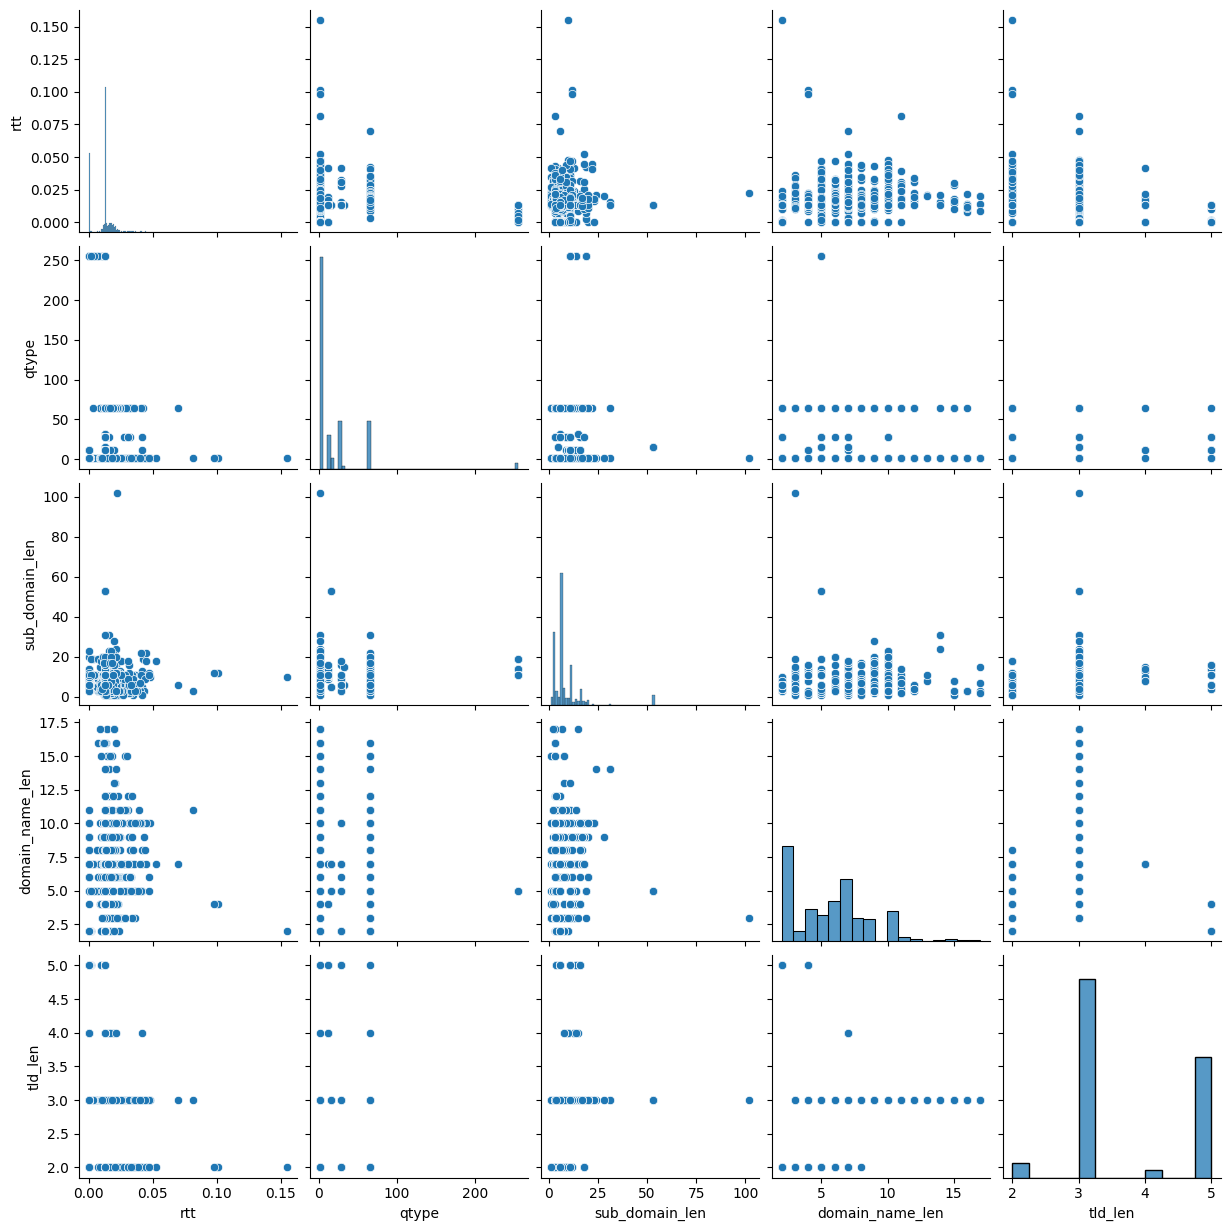

In [24]:
# Create a pairplot of the data to get a quick view
sns.pairplot(data=df_dns_numeric)

Some takeaways from above
- While most of the tld_len is at 3, we do have records where the tld is 5 characters
- Qtype len has a few values that are extremely long when compared to their pairs
- The domain_name_len seems to have somewhat of a normal distribution except for the large values on the left and some seeming very small values on the right
- Sub-domain lenght also looks interesting when scattered with rtt_new. We see most of them are bunched some some anomalies

Digging deeper


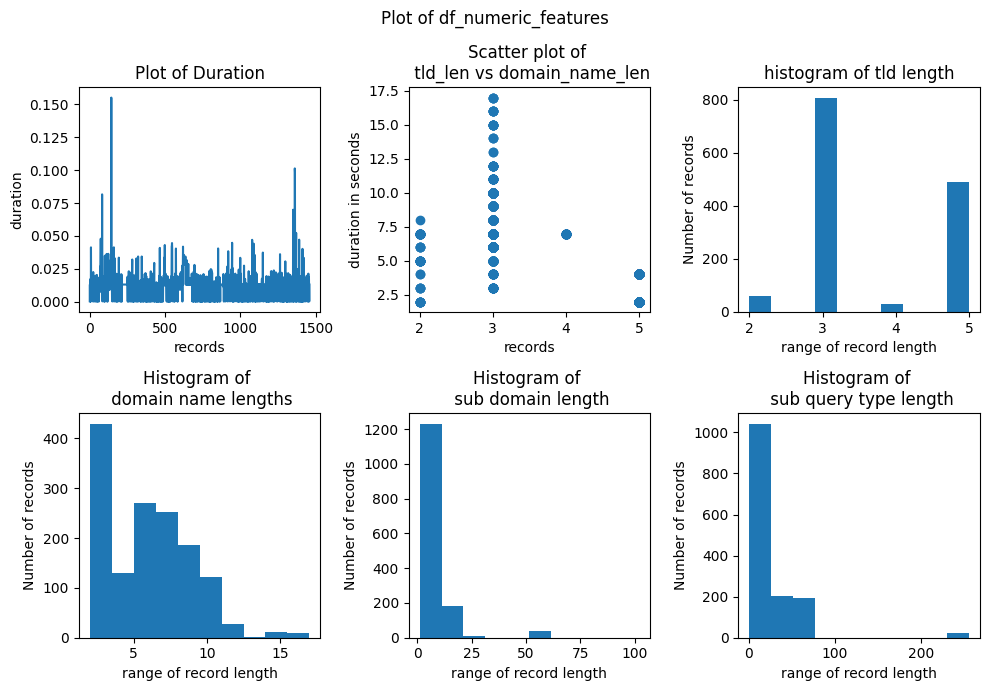

In [25]:
# Setup our own subplots for the data
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,7), sharex=False, sharey=False)
fig.suptitle(t='Plot of df_numeric_features')

# Plot the duration
ax[0][0].plot(df_dns_numeric['rtt'])
ax[0][0].set_xlabel('records')
ax[0][0].set_ylabel('duration')
ax[0][0].set_title('Plot of Duration')

# Scatter plot of Domain Length vs Top Level Domain Length
ax[0][1].scatter(x=df_dns_numeric['tld_len'], y=df_dns_numeric['domain_name_len'] )
ax[0][1].set_xlabel('records')
ax[0][1].set_ylabel('duration in seconds')
ax[0][1].set_title('Scatter plot of \n tld_len vs domain_name_len')

# Get a histogram of the lengths
ax[0][2].hist(x=df_dns_numeric['tld_len'])
ax[0][2].set_xlabel('range of record length')
ax[0][2].set_ylabel('Number of records')
ax[0][2].set_title('histogram of tld length')

# Get a histogram of the domain lengths
# We have a few records with a domain length beyond 11 characters
# a significant number of records are at around 3 chars
# Majority seems to be between 3 and 11 chars
ax[1][0].hist(x=df_dns_numeric['domain_name_len'])
ax[1][0].set_xlabel('range of record length')
ax[1][0].set_ylabel('Number of records')
ax[1][0].set_title('Histogram of \n domain name lengths')

# Get a histogram of the lengths of everything left of the domain
# Looks like the majority of records are around less than 24 bytes
# The ones that are larger are probably or anomalies
ax[1][1].hist(x=df_dns_numeric['sub_domain_len'])
ax[1][1].set_xlabel('range of record length')
ax[1][1].set_ylabel('Number of records')
ax[1][1].set_title('Histogram of \n sub domain length')

# Get a histogram of the query types
# Looks like the query types are mostly under 80
# We do see some pass 200
#   https://www.rfc-editor.org/rfc/rfc1035
ax[1][2].hist(x=df_dns_numeric['qtype'])
ax[1][2].set_xlabel('range of record length')
ax[1][2].set_ylabel('Number of records')
ax[1][2].set_title('Histogram of \n sub query type length')

fig.tight_layout()

In [26]:
# Before attempting to build any models let's peek into the data to find the records of interest from the graphs
# Starting with the records where the duration is greater than 0.050 seconds
df_dns_numeric[df_dns_numeric.rtt > 0.050]

,rtt,qtype,sub_domain_len,domain_name_len,tld_len
82,0.081590,1.0,3.0,11.0,3.0
143,0.155132,1.0,10.0,2.0,2.0
1350,0.069914,65.0,6.0,7.0,3.0
1361,0.101306,1.0,12.0,4.0,2.0
1362,0.098099,1.0,12.0,4.0,2.0
1370,0.052284,1.0,18.0,7.0,2.0


In [27]:
# We can even pull those records from the original dataset
# This gives us an opportunity to find where the host may be involved in suspicious communications
df_dns.iloc[[82, 143, 1350, 1361, 1362, 1370]]

,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,trans_id,rtt,query,qtype,sub_domain,domain_name,tld,sub_domain_len,domain_name_len,tld_len
82,10.10.0.52,64635,10.10.0.2,53,udp,58688.0,0.081590,www.securitynik.com,1.0,www,securitynik,com,3.0,11.0,3.0
143,10.10.0.24,8014,10.10.0.2,53,udp,34048.0,0.155132,collect-v6.51.la,1.0,collect-v6,51,la,10.0,2.0,2.0
1350,10.10.0.33,62817,10.10.0.2,53,udp,9931.0,0.069914,dealer.spotify.com,65.0,dealer,spotify,com,6.0,7.0,3.0
1361,10.10.0.52,59004,10.10.0.2,53,udp,40180.0,0.101306,somehost1234.gouv.fr,1.0,somehost1234,gouv,fr,12.0,4.0,2.0
1362,10.10.0.52,59004,64.71.255.198,53,udp,40180.0,0.098099,somehost1234.gouv.fr,1.0,somehost1234,gouv,fr,12.0,4.0,2.0
1370,10.10.0.4,50319,10.10.0.2,53,udp,54804.0,0.052284,artifacts.security.elastic.co,1.0,artifacts.security,elastic,co,18.0,7.0,2.0


In [28]:
# Finding where the tld is longer than 3 bytes
df_dns[df_dns['tld_len'] > 3]

,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,trans_id,rtt,query,qtype,sub_domain,domain_name,tld,sub_domain_len,domain_name_len,tld_len
1,10.10.0.4,35772,10.10.0.2,53,udp,28660.0,0.013045,33.0.10.10.in-addr.arpa,12.0,33.0.10.10,in-addr,arpa,10.0,7.0,4.0
2,10.10.0.4,36269,10.10.0.2,53,udp,458.0,0.000190,2.0.10.10.in-addr.arpa,12.0,2.0.10.10,in-addr,arpa,9.0,7.0,4.0
3,10.10.0.4,35237,10.10.0.2,53,udp,10874.0,0.013045,4.0.10.10.in-addr.arpa,12.0,4.0.10.10,in-addr,arpa,9.0,7.0,4.0
4,10.10.0.4,54360,10.10.0.2,53,udp,11233.0,0.017187,25.224.186.35.in-addr.arpa,12.0,25.224.186.35,in-addr,arpa,13.0,7.0,4.0
5,10.10.0.4,40457,10.10.0.2,53,udp,9401.0,0.000222,52.0.10.10.in-addr.arpa,12.0,52.0.10.10,in-addr,arpa,10.0,7.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1443,10.10.0.4,37556,10.10.0.2,53,udp,28269.0,0.013045,labsys.sn.local,28.0,labsys,sn,local,6.0,2.0,5.0
1449,10.10.0.10,5353,224.0.0.251,5353,udp,2485.0,0.013045,_googlecast._tcp.local,12.0,_googlecast,_tcp,local,11.0,4.0,5.0
1450,10.10.0.52,51394,10.10.0.2,53,udp,21197.0,0.000227,labsys.sn.local,1.0,labsys,sn,local,6.0,2.0,5.0
1457,10.10.0.4,45990,10.10.0.2,53,udp,65144.0,0.000254,labsys.sn.local,1.0,labsys,sn,local,6.0,2.0,5.0


In [29]:
# One more, find the records where the sub_domain_length is greater than 
# Now this looks interesting
# Do you know why?
df_dns[df_dns['sub_domain_len'] > 20]


,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,trans_id,rtt,query,qtype,sub_domain,domain_name,tld,sub_domain_len,domain_name_len,tld_len
212,10.10.0.4,53530,10.10.0.2,53,udp,34863.0,0.013045,635c64770d1664d6f5c58a2e25e3fe9db70ee3f7.malwa...,16.0,635c64770d1664d6f5c58a2e25e3fe9db70ee3f7.malwa...,cymru,com,53.0,5.0,3.0
214,10.10.0.4,53308,10.10.0.2,53,udp,42814.0,0.013045,7aeadfd88405ffe3046a740d6c13b04207342895.malwa...,16.0,7aeadfd88405ffe3046a740d6c13b04207342895.malwa...,cymru,com,53.0,5.0,3.0
215,10.10.0.4,39989,10.10.0.2,53,udp,30161.0,0.013045,5cecdeb7bb53ca50d29e6ed6323f2868dee68531.malwa...,16.0,5cecdeb7bb53ca50d29e6ed6323f2868dee68531.malwa...,cymru,com,53.0,5.0,3.0
216,10.10.0.4,53038,10.10.0.2,53,udp,9409.0,0.013045,5ed45c1af65b06bc1eeb3fbbbec4c7203b55806a.malwa...,16.0,5ed45c1af65b06bc1eeb3fbbbec4c7203b55806a.malwa...,cymru,com,53.0,5.0,3.0
217,10.10.0.4,45218,10.10.0.2,53,udp,27001.0,0.013045,4b6fdd360a8e1db6ba6a41221366ce2261489c6b.malwa...,16.0,4b6fdd360a8e1db6ba6a41221366ce2261489c6b.malwa...,cymru,com,53.0,5.0,3.0
218,10.10.0.4,48835,10.10.0.2,53,udp,11605.0,0.013045,8569674e33a187d032f6e7b4dddaf716a42cb868.malwa...,16.0,8569674e33a187d032f6e7b4dddaf716a42cb868.malwa...,cymru,com,53.0,5.0,3.0
219,10.10.0.4,40688,10.10.0.2,53,udp,51131.0,0.013045,244f2b6b0ea28ae143485ef50094f3a6b7418839.malwa...,16.0,244f2b6b0ea28ae143485ef50094f3a6b7418839.malwa...,cymru,com,53.0,5.0,3.0
220,10.10.0.4,59607,10.10.0.2,53,udp,63446.0,0.013045,614499e7ec193ffd55459917e8c8c2e2849e1748.malwa...,16.0,614499e7ec193ffd55459917e8c8c2e2849e1748.malwa...,cymru,com,53.0,5.0,3.0
221,10.10.0.4,40796,10.10.0.2,53,udp,41358.0,0.013045,94ffbba4bf66a10aeabf27cb1e21204fca4e26b4.malwa...,16.0,94ffbba4bf66a10aeabf27cb1e21204fca4e26b4.malwa...,cymru,com,53.0,5.0,3.0
222,10.10.0.4,60207,10.10.0.2,53,udp,31469.0,0.013045,bd38a7481d8cacbfd05bc92111a708021575d658.malwa...,16.0,bd38a7481d8cacbfd05bc92111a708021575d658.malwa...,cymru,com,53.0,5.0,3.0


In [30]:
# Take a closer look at 12
# This looks like some type of malware hash lookup, using team cymru
df_dns.iloc[212]

id.orig_h                                                  10.10.0.4
id.orig_p                                                      53530
id.resp_h                                                  10.10.0.2
id.resp_p                                                         53
proto                                                            udp
trans_id                                                     34863.0
rtt                                                         0.013045
query              635c64770d1664d6f5c58a2e25e3fe9db70ee3f7.malwa...
qtype                                                           16.0
sub_domain         635c64770d1664d6f5c58a2e25e3fe9db70ee3f7.malwa...
domain_name                                                    cymru
tld                                                              com
sub_domain_len                                                  53.0
domain_name_len                                                  5.0
tld_len                           

In [31]:
# Peak into all the unique source IPs
df_dns['id.orig_h'].unique()

array(['10.10.0.33', '10.10.0.4', '10.10.0.24', '10.10.0.10',
       '10.10.0.32', '10.10.0.52', '10.10.0.8', '10.10.0.74',
       'fe80::28b8:f1b7:bf3c:fa0d', 'fe80::f5d8:dd03:d70c:d8e5',
       'fe80::ce25:4f71:339:bac9', '10.10.0.31', '10.10.0.95',
       '10.10.0.56', '10.10.0.59'], dtype=object)

In [32]:
# Get a better view
df_dns['id.orig_h'].value_counts()

id.orig_h
10.10.0.4                    393
10.10.0.33                   343
10.10.0.24                   209
10.10.0.52                   194
10.10.0.74                    88
10.10.0.10                    68
10.10.0.32                    48
10.10.0.95                    26
10.10.0.8                     22
10.10.0.31                    22
fe80::f5d8:dd03:d70c:d8e5     15
fe80::28b8:f1b7:bf3c:fa0d     13
fe80::ce25:4f71:339:bac9      12
10.10.0.56                     4
10.10.0.59                     2
Name: count, dtype: int64

In [33]:
# We can go on and on with analyzing this data.
# However, we have to get to the point where we decide to move on
# For this purpose, let's move on

# Importing the scaler 
from sklearn.preprocessing import MinMaxScaler

In [34]:
# Setup and train the scaler
min_max_scaler = MinMaxScaler(feature_range=(0,1), copy=True)
min_max_scaler

MinMaxScaler()

In [35]:
# Fit on the data
min_max_scaler.fit(X=X.values, y=None)

# Transform the data
X_scaled = min_max_scaler.transform(X=X.values)

# View the data
X_scaled

array([[0.33333333, 0.33333333, 0.00207608, 0.        , 0.04950495],
       [0.33333333, 0.66666667, 0.08389749, 0.04330709, 0.08910891],
       [0.33333333, 0.66666667, 0.0010187 , 0.04330709, 0.07920792],
       ...,
       [0.06666667, 0.33333333, 0.06805932, 0.        , 0.02970297],
       [0.        , 1.        , 0.00143133, 0.        , 0.04950495],
       [0.        , 1.        , 0.08389749, 0.10629921, 0.04950495]])

In [36]:
# Keeping it simple. Focusing only on one algorithm.
# For this purpose I choose Local Outlier Factor 
# It will be used with novelty=True, hence Novelty Detection
# Local Outlier Factor was covered in
#   08 - Beginning Machine Learning Anomaly Detection - Isolation Forest and Local Outlier Factor 
from sklearn.neighbors import LocalOutlierFactor

In [37]:
# Setup the Local Outlier Factor
# Note novelty=True, hence novelty detection
clf_local_outlier_factor = LocalOutlierFactor(n_neighbors=20, algorithm='auto', \
                                              metric='minkowski', p=2, contamination='auto', novelty=True, n_jobs=-1)
clf_local_outlier_factor

LocalOutlierFactor(n_jobs=-1, novelty=True)

In [38]:
# Train the model
# I know I'm training on the entire dataset.
# We all know we should have Train, Test and or Validation splits.
clf_local_outlier_factor.fit(X=X_scaled, y=None)

# Make predictions on all the training data
predictions = clf_local_outlier_factor.predict(X=X_scaled)
predictions

array([1, 1, 1, ..., 1, 1, 1])

In [39]:
# Get the negative outlier factor
# The higher the score more normal
# Negative outlier tends to have scores closers to -1  
#   https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor
clf_local_outlier_factor.negative_outlier_factor_

array([-0.99999558, -1.00868306, -0.96420551, ..., -0.98718064,
       -1.00833843, -1.        ])

In [40]:
# Get the decision function
# "Bigger is better, i.e. large values correspond to inliers."
clf_local_outlier_factor.decision_function(X)

array([-3.23047844e+01, -1.36701254e+02, -1.31957488e+02, ...,
       -2.88834868e+10, -7.01257685e+10, -2.31332354e+02])

In [41]:
# Get the score_samples
# "Bigger is better, i.e. large values correspond to inliers.
clf_local_outlier_factor.score_samples(X=X)

array([-3.38047844e+01, -1.38201254e+02, -1.33457488e+02, ...,
       -2.88834868e+10, -7.01257685e+10, -2.32832354e+02])

In [42]:
# Get the results of the returned predictions
dict(zip(np.unique(ar=predictions, return_counts=True)[0], np.unique(ar=predictions, return_counts=True)[1]))

{-1: 178, 1: 1281}

In [43]:
#  Add these labels to the original dataset
df_dns['predictions'] = predictions.reshape(-1,1)

# Add the negative outlier scores
df_dns['negative_outlier'] = clf_local_outlier_factor.negative_outlier_factor_.reshape(-1, 1)

# Review the dataset
df_dns

,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,trans_id,rtt,query,qtype,sub_domain,domain_name,tld,sub_domain_len,domain_name_len,tld_len,predictions,negative_outlier
0,10.10.0.33,49925,10.10.0.2,53,udp,28568.0,0.000354,dealer.spotify.com,1.0,dealer,spotify,com,6.0,7.0,3.0,1,-0.999996
1,10.10.0.4,35772,10.10.0.2,53,udp,28660.0,0.013045,33.0.10.10.in-addr.arpa,12.0,33.0.10.10,in-addr,arpa,10.0,7.0,4.0,1,-1.008683
2,10.10.0.4,36269,10.10.0.2,53,udp,458.0,0.000190,2.0.10.10.in-addr.arpa,12.0,2.0.10.10,in-addr,arpa,9.0,7.0,4.0,1,-0.964206
3,10.10.0.4,35237,10.10.0.2,53,udp,10874.0,0.013045,4.0.10.10.in-addr.arpa,12.0,4.0.10.10,in-addr,arpa,9.0,7.0,4.0,1,-1.008357
4,10.10.0.4,54360,10.10.0.2,53,udp,11233.0,0.017187,25.224.186.35.in-addr.arpa,12.0,25.224.186.35,in-addr,arpa,13.0,7.0,4.0,1,-1.001132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,10.10.0.52,49963,10.10.0.2,53,udp,12012.0,0.016614,teams.events.data.microsoft.com,65.0,teams.events.data,microsoft,com,17.0,9.0,3.0,-1,-1.644559
1455,10.10.0.52,54029,10.10.0.2,53,udp,38566.0,0.018393,teams.events.data.microsoft.com,1.0,teams.events.data,microsoft,com,17.0,9.0,3.0,1,-0.986692
1456,10.10.0.32,49937,10.10.0.2,53,udp,2.0,0.010588,pool.ntp.org,1.0,pool,ntp,org,4.0,3.0,3.0,1,-0.987181
1457,10.10.0.4,45990,10.10.0.2,53,udp,65144.0,0.000254,labsys.sn.local,1.0,labsys,sn,local,6.0,2.0,5.0,1,-1.008338


In [44]:
# Now we can analyze all those records that the algorithm considers outliers
df_dns[df_dns.predictions == -1 ]

,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,trans_id,rtt,query,qtype,sub_domain,domain_name,tld,sub_domain_len,domain_name_len,tld_len,predictions,negative_outlier
8,10.10.0.4,34221,10.10.0.2,53,udp,19128.0,0.041297,134.43.190.35.in-addr.arpa,12.0,134.43.190.35,in-addr,arpa,13.0,7.0,4.0,-1,-1.817509e+00
61,10.10.0.52,58225,10.10.0.2,53,udp,46222.0,0.000202,googleads.g.doubleclick.net,1.0,googleads.g,doubleclick,net,11.0,11.0,3.0,-1,-1.636413e+00
81,10.10.0.52,61228,10.10.0.2,53,udp,7923.0,0.012027,apis.google.com,1.0,apis,google,com,4.0,6.0,3.0,-1,-6.630837e+07
82,10.10.0.52,64635,10.10.0.2,53,udp,58688.0,0.081590,www.securitynik.com,1.0,www,securitynik,com,3.0,11.0,3.0,-1,-2.821768e+00
95,10.10.0.24,33779,64.71.255.198,53,udp,61695.0,0.015102,www.google.com,1.0,www,google,com,3.0,6.0,3.0,-1,-1.012806e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1417,10.10.0.52,53175,10.10.0.2,53,udp,19754.0,0.000211,wpad.sn.local,1.0,wpad,sn,local,4.0,2.0,5.0,-1,-2.249043e+02
1418,10.10.0.52,49221,10.10.0.2,53,udp,6965.0,0.013045,wpad.sn.local,65.0,wpad,sn,local,4.0,2.0,5.0,-1,-1.470091e+09
1424,10.10.0.52,51394,10.10.0.2,53,udp,47684.0,0.000230,wpad.sn.local,1.0,wpad,sn,local,4.0,2.0,5.0,-1,-2.978266e+02
1428,10.10.0.52,51394,10.10.0.2,53,udp,33326.0,0.018188,www.google.com,1.0,www,google,com,3.0,6.0,3.0,-1,-1.022583e+08


In [45]:
# Add the decision function output to the dataframe
df_dns['decision_function'] = clf_local_outlier_factor.decision_function(X).reshape(-1, 1)
df_dns

,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,trans_id,rtt,query,qtype,sub_domain,domain_name,tld,sub_domain_len,domain_name_len,tld_len,predictions,negative_outlier,decision_function
0,10.10.0.33,49925,10.10.0.2,53,udp,28568.0,0.000354,dealer.spotify.com,1.0,dealer,spotify,com,6.0,7.0,3.0,1,-0.999996,-3.230478e+01
1,10.10.0.4,35772,10.10.0.2,53,udp,28660.0,0.013045,33.0.10.10.in-addr.arpa,12.0,33.0.10.10,in-addr,arpa,10.0,7.0,4.0,1,-1.008683,-1.367013e+02
2,10.10.0.4,36269,10.10.0.2,53,udp,458.0,0.000190,2.0.10.10.in-addr.arpa,12.0,2.0.10.10,in-addr,arpa,9.0,7.0,4.0,1,-0.964206,-1.319575e+02
3,10.10.0.4,35237,10.10.0.2,53,udp,10874.0,0.013045,4.0.10.10.in-addr.arpa,12.0,4.0.10.10,in-addr,arpa,9.0,7.0,4.0,1,-1.008357,-1.319572e+02
4,10.10.0.4,54360,10.10.0.2,53,udp,11233.0,0.017187,25.224.186.35.in-addr.arpa,12.0,25.224.186.35,in-addr,arpa,13.0,7.0,4.0,1,-1.001132,-1.527017e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,10.10.0.52,49963,10.10.0.2,53,udp,12012.0,0.016614,teams.events.data.microsoft.com,65.0,teams.events.data,microsoft,com,17.0,9.0,3.0,-1,-1.644559,-5.524250e+02
1455,10.10.0.52,54029,10.10.0.2,53,udp,38566.0,0.018393,teams.events.data.microsoft.com,1.0,teams.events.data,microsoft,com,17.0,9.0,3.0,1,-0.986692,-1.415412e+11
1456,10.10.0.32,49937,10.10.0.2,53,udp,2.0,0.010588,pool.ntp.org,1.0,pool,ntp,org,4.0,3.0,3.0,1,-0.987181,-2.888349e+10
1457,10.10.0.4,45990,10.10.0.2,53,udp,65144.0,0.000254,labsys.sn.local,1.0,labsys,sn,local,6.0,2.0,5.0,1,-1.008338,-7.012577e+10


In [46]:
# Add the score samples to the dataframe
df_dns['score_samples'] = clf_local_outlier_factor.score_samples(X=X)
df_dns

,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,trans_id,rtt,query,qtype,sub_domain,domain_name,tld,sub_domain_len,domain_name_len,tld_len,predictions,negative_outlier,decision_function,score_samples
0,10.10.0.33,49925,10.10.0.2,53,udp,28568.0,0.000354,dealer.spotify.com,1.0,dealer,spotify,com,6.0,7.0,3.0,1,-0.999996,-3.230478e+01,-3.380478e+01
1,10.10.0.4,35772,10.10.0.2,53,udp,28660.0,0.013045,33.0.10.10.in-addr.arpa,12.0,33.0.10.10,in-addr,arpa,10.0,7.0,4.0,1,-1.008683,-1.367013e+02,-1.382013e+02
2,10.10.0.4,36269,10.10.0.2,53,udp,458.0,0.000190,2.0.10.10.in-addr.arpa,12.0,2.0.10.10,in-addr,arpa,9.0,7.0,4.0,1,-0.964206,-1.319575e+02,-1.334575e+02
3,10.10.0.4,35237,10.10.0.2,53,udp,10874.0,0.013045,4.0.10.10.in-addr.arpa,12.0,4.0.10.10,in-addr,arpa,9.0,7.0,4.0,1,-1.008357,-1.319572e+02,-1.334572e+02
4,10.10.0.4,54360,10.10.0.2,53,udp,11233.0,0.017187,25.224.186.35.in-addr.arpa,12.0,25.224.186.35,in-addr,arpa,13.0,7.0,4.0,1,-1.001132,-1.527017e+02,-1.542017e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,10.10.0.52,49963,10.10.0.2,53,udp,12012.0,0.016614,teams.events.data.microsoft.com,65.0,teams.events.data,microsoft,com,17.0,9.0,3.0,-1,-1.644559,-5.524250e+02,-5.539250e+02
1455,10.10.0.52,54029,10.10.0.2,53,udp,38566.0,0.018393,teams.events.data.microsoft.com,1.0,teams.events.data,microsoft,com,17.0,9.0,3.0,1,-0.986692,-1.415412e+11,-1.415412e+11
1456,10.10.0.32,49937,10.10.0.2,53,udp,2.0,0.010588,pool.ntp.org,1.0,pool,ntp,org,4.0,3.0,3.0,1,-0.987181,-2.888349e+10,-2.888349e+10
1457,10.10.0.4,45990,10.10.0.2,53,udp,65144.0,0.000254,labsys.sn.local,1.0,labsys,sn,local,6.0,2.0,5.0,1,-1.008338,-7.012577e+10,-7.012577e+10


<Axes: title={'center': 'Negative Outlier Factor'}>

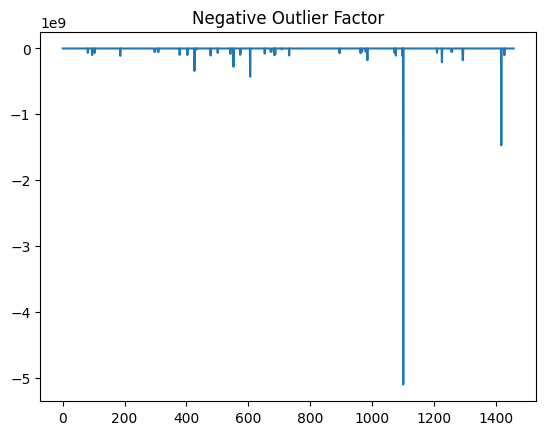

In [47]:
# Visualize the negative outlier scores
# We can then start with analyzing those that have values between -2 and -5
df_dns['negative_outlier'].plot(title='Negative Outlier Factor')

In [48]:
# Find those records with values less than -60
# Below, many of these records seems to be of no major concern. 
# However, there is one I am definitely interested in
df_dns[df_dns['negative_outlier'] < -60. ]

,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,trans_id,rtt,query,qtype,sub_domain,domain_name,tld,sub_domain_len,domain_name_len,tld_len,predictions,negative_outlier,decision_function,score_samples
81,10.10.0.52,61228,10.10.0.2,53,udp,7923.0,0.012027,apis.google.com,1.0,apis,google,com,4.0,6.0,3.0,-1,-6.630837e+07,-2.581897e+01,-2.731897e+01
95,10.10.0.24,33779,64.71.255.198,53,udp,61695.0,0.015102,www.google.com,1.0,www,google,com,3.0,6.0,3.0,-1,-1.012806e+08,-2.385274e+01,-2.535274e+01
103,10.10.0.24,61178,10.10.0.2,53,udp,24230.0,0.011800,play.google.com,1.0,play,google,com,4.0,6.0,3.0,-1,-6.908335e+07,-2.581898e+01,-2.731898e+01
186,10.10.0.24,42602,64.71.255.198,53,udp,17865.0,0.016027,www.google.com,1.0,www,google,com,3.0,6.0,3.0,-1,-1.121902e+08,-2.385269e+01,-2.535269e+01
296,10.10.0.52,5353,224.0.0.251,5353,udp,NaN,0.013045,_microsoft_mcc._tcp.local,12.0,_microsoft_mcc,_tcp,local,14.0,4.0,5.0,-1,-4.950495e+07,-1.475448e+02,-1.490448e+02
297,10.10.0.52,5353,224.0.0.251,5353,udp,NaN,0.013045,_microsoft_mcc._tcp.local,12.0,_microsoft_mcc,_tcp,local,14.0,4.0,5.0,-1,-4.950495e+07,-1.475448e+02,-1.490448e+02
298,fe80::f5d8:dd03:d70c:d8e5,5353,ff02::fb,5353,udp,NaN,0.013045,_microsoft_mcc._tcp.local,12.0,_microsoft_mcc,_tcp,local,14.0,4.0,5.0,-1,-4.950495e+07,-1.475448e+02,-1.490448e+02
299,fe80::f5d8:dd03:d70c:d8e5,5353,ff02::fb,5353,udp,NaN,0.013045,_microsoft_mcc._tcp.local,12.0,_microsoft_mcc,_tcp,local,14.0,4.0,5.0,-1,-4.950495e+07,-1.475448e+02,-1.490448e+02
301,10.10.0.33,49367,10.10.0.2,53,udp,62299.0,0.000235,wpad.sn.local,1.0,wpad,sn,local,4.0,2.0,5.0,-1,-3.192579e+02,-5.936383e+10,-5.936383e+10
309,10.10.0.24,33190,64.71.255.198,53,udp,48787.0,0.011994,www.google.com,1.0,www,google,com,3.0,6.0,3.0,-1,-5.683930e+07,-2.385291e+01,-2.535291e+01


In [49]:
# Find those records with values less than -5e9
# This record definitely looks interesting
df_dns[df_dns['negative_outlier'] < -5e9 ]

,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,trans_id,rtt,query,qtype,sub_domain,domain_name,tld,sub_domain_len,domain_name_len,tld_len,predictions,negative_outlier,decision_function,score_samples
1101,10.10.0.59,60483,10.10.0.2,53,udp,49411.0,0.022409,d3c568d0e8fc3b3b1bd20bf83efe6f8dff8df8064b6bd7...,1.0,d3c568d0e8fc3b3b1bd20bf83efe6f8dff8df8064b6bd7...,a2z,com,102.0,3.0,3.0,-1,-5.101762e+09,-9.646219e+11,-9.646219e+11


In [50]:
# Looking at this from a different perspective
# The one field missing here, that would make this threat hunting easier, is the date. 
# With the date, we can go back directly to that point in time
# However, since we used components of a Zeek input for this analysis, we can go back to that original file
df_dns.iloc[1101]

id.orig_h                                                   10.10.0.59
id.orig_p                                                        60483
id.resp_h                                                    10.10.0.2
id.resp_p                                                           53
proto                                                              udp
trans_id                                                       49411.0
rtt                                                           0.022409
query                d3c568d0e8fc3b3b1bd20bf83efe6f8dff8df8064b6bd7...
qtype                                                              1.0
sub_domain           d3c568d0e8fc3b3b1bd20bf83efe6f8dff8df8064b6bd7...
domain_name                                                        a2z
tld                                                                com
sub_domain_len                                                   102.0
domain_name_len                                                    3.0
tld_le

<Axes: title={'center': 'Decision Funciton'}>

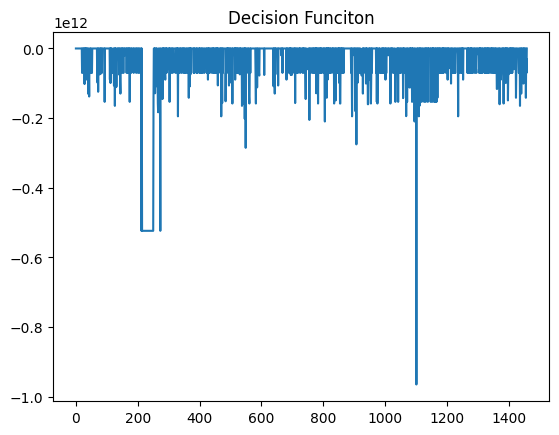

In [51]:
# Plot the decision functions
df_dns['decision_function'].plot(title='Decision Funciton')

As always you can spend forever doing the analysis of this data
I do not plan to do that.
Moving on
Considering we used novelt=True above to make predictions on future data, let's create a sample
When we receive the DNS log file, there are 3 fields that we need,
These are rtt, qtype and query
From these two fields, we create
    domain_name_len	tld_len	rtt	qtype	sub_domain_len

In [52]:
# Setting up a sample
new_sample = pd.DataFrame(data=[[10, 1, 'hack-n-detect.securitynik.local' ]], columns=['rtt', 'qtype', 'query'])
new_sample

,rtt,qtype,query
0,10,1,hack-n-detect.securitynik.local


In [53]:
# Remember testing data has to pass through the same preprocessing as training data
def preprocessing(sample=None):
    ''' Preprocess the data for prediction '''
    tmp_df = sample
    tmp_df[['sub_domain', 'domain_name', 'tld']] = tmp_df['query'].str.rsplit(pat='.', n=2, expand=True)

    # Create new columns with these lengths
    tmp_df['sub_domain_len'] = tmp_df['sub_domain'].str.len().astype(float)
    tmp_df['domain_name_len'] = tmp_df['domain_name'].str.len().astype(float)
    tmp_df['tld_len'] = tmp_df['tld'].str.len().astype(float)

    # Create a new dataframe
    df = pd.DataFrame()

    # Reconstruct the feaures, the same order they were used during the training
    df[['domain_name_len', 'tld_len', 'rtt', 'qtype', 'sub_domain_len']] = \
        tmp_df[['domain_name_len', 'tld_len', 'rtt', 'qtype', 'sub_domain_len']]

    # Scale the df
    X = min_max_scaler.transform(df.values)
    # The qtype is currently an int field, let's change it to float
    #df_dns['qtype'] = df_dns['qtype'].astype(float)

    # Peek into the new data
    #df_dns
        
    return df, X


In [54]:
# Get the preprocessed data
X, df = preprocessing(sample=new_sample)
X, df

(   domain_name_len  tld_len  rtt  qtype  sub_domain_len
 0             11.0      5.0   10      1            13.0,
 array([[ 0.6       ,  1.        , 64.47432624,  0.        ,  0.11881188]]))

In [55]:
# Make a prediction and get the score_sample
clf_local_outlier_factor.predict(X), clf_local_outlier_factor.score_samples(X=X)

(array([-1]), array([-80.22511715]))

In [56]:
# Let's use these two to trigger an alert
# Import datetime library
from datetime import datetime

In [57]:
# Trigger an alert when a sample's is predicted -1 and has a score over -50
f'{datetime.now()} - [!] ALERT ** SUSPICIOUS ACTIVITY ** Zeek dns.log' \
    if ( clf_local_outlier_factor.predict(X) == -1 and clf_local_outlier_factor.score_samples(X=X) < -80. ) \
        else "[**] Normal Traffic"

'2023-05-28 23:08:49.723834 - [!] ALERT ** SUSPICIOUS ACTIVITY ** Zeek dns.log'

In [58]:
# Prepare to save the model
import joblib
import os

In [59]:
# Create the location to save the model
PATH = './SAVED_MODELS/zeek_dns_lof/'
MODELS_PATH = os.makedirs(name=PATH, exist_ok=True)

# Save the model
joblib.dump(value=clf_local_outlier_factor, filename=f'{PATH}/model_zeek_dns_lof.joblib')

['./SAVED_MODELS/zeek_dns_lof//model_zeek_dns_lof.joblib']

In [60]:
# Load the model
loaded_clf_lof_model = joblib.load(filename='./SAVED_MODELS/zeek_dns_lof//model_zeek_dns_lof.joblib')
loaded_clf_lof_model

LocalOutlierFactor(n_jobs=-1, novelty=True)

In [61]:
loaded_clf_lof_model.predict(X)

array([-1])

# Additional References
https://whc.ca/blog/beginners-guide-to-dns-and-nameservers-2020-edition/ <br>
https://condor.depaul.edu/~jkristof/tdc375/2012_13-901/dns101-nanog57.pdf <br>